# Fine-tuning DocTR for Detection

## Step 1: Environment Setup 

In [1]:
print("="*100)
print("Step 1: Environment Setup")
print("="*100+"\n")

import os
import json
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import torch 
from torch.utils.data import DataLoader, ConcatDataset


print("Uninstalling existing PyTorch and torchvision to ensure clean install")
!pip uninstall torch torchvision torchaudio -y --quiet
print("Uninstallation complete.")

print("Installing PyTorch and torchvision")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --quiet
print("PyTorch and torchvision installation complete.")

print("Installing python-doctr[torch]...")
!pip install "python-doctr[torch]==0.11.0" --quiet
print("doctr installation complete.")

print("\nConfiguring GPU")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

print(f"Device set to: {device}")

print("\nDefining dataset base path...")
base_path = '/kaggle/input/xfund-and-funsd/XFUND and FUNSD/'
print(f"Dataset base path set to: {base_path}")

print("\n"+"="*100)
print("Step 1 Complete")
print("="*100)

Step 1: Environment Setup

Uninstalling existing PyTorch and torchvision to ensure clean install
Uninstallation complete.
Installing PyTorch and torchvision
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00:00:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 768.5/768.5 MB 1.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━

## Step 2: Prepare Dataset for Detection Fine-tuning

In [ ]:
print("="*100)
print("Step 2: Preparing Dataset for Detection Fine-tuning")
print("="*100+"\n")


import os
import json
from PIL import Image
import numpy as np
import torchvision.transforms as T_vision
import torch.utils.data as data
from torch.utils.data import ConcatDataset


base_path = '/kaggle/input/xfund-and-funsd/XFUND and FUNSD/'

languages = ['de', 'en', 'es', 'fr', 'it', 'ja', 'pt', 'zh']

class XFUND_FUNSD_DetectionDataset(data.Dataset):
    def __init__(self, img_folder, json_path, transforms=None):
        self.img_folder = img_folder
        self.json_path = json_path
        self.transforms = transforms

        with open(self.json_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)

        self.samples = []
        for doc_info in self.data['documents']:
            doc_id = doc_info['id']
            img_path_png = os.path.join(self.img_folder, f"{doc_id}.png")
            img_path_jpg = os.path.join(self.img_folder, f"{doc_id}.jpg")

            img_path = None
            if os.path.exists(img_path_png):
                img_path = img_path_png
            elif os.path.exists(img_path_jpg):
                img_path = img_path_jpg

            if img_path is None:
                print(f"Warning: Image not found for document '{doc_id}' at {img_path_png} or {img_path_jpg}. Skipping document.")
                continue

            boxes_raw = []
            for block in doc_info['document']:
                boxes_raw.append(block['box'])

            if boxes_raw: 
                self.samples.append((img_path, np.array(boxes_raw, dtype=np.float32)))
            else:
                print(f"Warning: No text boxes found for document '{doc_id}'. Skipping.")

    def __getitem__(self, idx):
        img_path, raw_boxes = self.samples[idx]

        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        norm_boxes = raw_boxes / np.array([width, height, width, height], dtype=np.float32)

        if norm_boxes.ndim == 1:
            norm_boxes = norm_boxes.reshape(1, -1)

        if norm_boxes.shape[1] == 4:
            class_ids = np.zeros((norm_boxes.shape[0], 1), dtype=np.float32)
            norm_boxes = np.hstack((norm_boxes, class_ids))
        elif norm_boxes.shape[1] != 5:
            raise ValueError(f"Unexpected box shape after normalization: {norm_boxes.shape}. Expected (N, 4) or (N, 5).")

        if self.transforms:
            img = self.transforms(img)

        return img, norm_boxes

    def __len__(self):
        return len(self.samples)
 
print("Custom Dataset classes defined.")

print("\nInitializing datasets for all languages")

detection_train_datasets_list = []
detection_val_datasets_list = [] 

for lang in languages:
    print(f"Processing language: {lang}")
    img_train_folder = os.path.join(base_path, f'{lang}.train')
    json_train_path = os.path.join(base_path, f'{lang}.train.json')
    img_val_folder = os.path.join(base_path, f'{lang}.val')
    json_val_path = os.path.join(base_path, f'{lang}.val.json')

    detection_train_transforms = T_vision.Compose([
        T_vision.Resize((800, 800)),
        T_vision.ToTensor(),
        T_vision.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    detection_val_transforms = T_vision.Compose([
        T_vision.Resize((800, 800)),
        T_vision.ToTensor(),
        T_vision.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]) 
    
    det_train_ds = XFUND_FUNSD_DetectionDataset(img_train_folder, json_train_path, transforms=detection_train_transforms)
    det_val_ds = XFUND_FUNSD_DetectionDataset(img_val_folder, json_val_path, transforms=detection_val_transforms)
 
    detection_train_datasets_list.append(det_train_ds)
    detection_val_datasets_list.append(det_val_ds) 

all_detection_train_data = ConcatDataset(detection_train_datasets_list)
all_detection_val_data = ConcatDataset(detection_val_datasets_list) 


print(f"\nTotal detection training samples: {len(all_detection_train_data)}")
print(f"Total detection validation samples: {len(all_detection_val_data)}") 

print("\n"+"="*100)
print("Step 2 Complete")
print("="*100)

## Step 3: Creating DataLoaders and Collate function for Detection Fine-tuning

In [ ]:
print("="*100)
print("Step 3: Creating DataLoaders and Collate function for Detection Fine-tuning")
print("="*100+"\n")


from torch.utils.data import DataLoader, ConcatDataset
import torch
  

def detection_collate_fn(batch):
    images = [item[0] for item in batch]
    boxes = [item[1] for item in batch]
    images_batch = torch.stack(images, 0)
    return images_batch, boxes
 


detection_batch_size = 8 

num_workers = 2

detection_train_dataloader = DataLoader(
    all_detection_train_data,
    batch_size=detection_batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=detection_collate_fn,
    pin_memory=True
)

detection_val_dataloader = DataLoader(
    all_detection_val_data,
    batch_size=detection_batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=detection_collate_fn,
    pin_memory=True
)
 

print("\n"+"="*100)
print("Step 3 Complete")
print("="*100)

## Step 4: Detection Model Setup


In [ ]:
print("="*100)
print("Step 4: Detection Model Setup")
print("="*100+"\n")

from doctr.models import detection_predictor  
from doctr.models.detection import db_resnet50  
from torch.optim import AdamW  
import torch.nn as nn  
 
print("\nSetting up Detection Model (DBNet ResNet-50)...")
detector = db_resnet50(pretrained=True, pretrained_backbone=True).to(device)
print("Detection model loaded and moved to device.")
 
 
print("\nSetting up Optimizer...")
detector_optimizer = AdamW(detector.parameters(), lr=1e-4)
print("Detection optimizer (AdamW) created.")
  

print("\n"+"="*100)
print("Step 4 Complete")
print("="*100)

## Step 5: Detection Training Setup and Execution

In [ ]:
print("="*100)
print("Step 5: Detection Training Setup and Execution")
print("="*100+"\n")

import torch.cuda.amp as amp
import torch.nn.functional as F
import time
import math
import numpy as np
import torch
from doctr.utils.metrics import DetectionMetric, OCRMetric  

print("Starting Step 5: Training Loop...")

 
num_epochs_detection = 25   

detection_grad_acc_steps = 4 

log_interval = 100
eval_interval = 1

scaler = torch.amp.GradScaler( )
 
detection_train_losses = []
detection_val_losses = []  

def train_detection_one_epoch(epoch, model, dataloader, optimizer, scaler, grad_acc_steps, log_interval, device):
    model.train()
    total_loss = 0
    start_time = time.time()

    for batch_idx, (images, gt_boxes) in enumerate(dataloader):
        images = images.to(device)

        targets_for_doctr = []
        for boxes_np_array in gt_boxes:
            targets_for_doctr.append({'boxes': boxes_np_array.astype(np.float32)})

        with torch.amp.autocast(device_type=device.type):
            outputs = model(images, targets_for_doctr)
            loss = outputs['loss']
            loss = loss / grad_acc_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % grad_acc_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_acc_steps

        if (batch_idx + 1) % log_interval == 0:
            elapsed_time = time.time() - start_time
            print(f"Det Train Epoch: {epoch} [{batch_idx*len(images)}/{len(dataloader.dataset)} "
                  f"({100. * batch_idx / len(dataloader):.0f}%)]\t"
                  f"Loss: {total_loss / (batch_idx + 1):.6f}")
            start_time = time.time()

    if (batch_idx + 1) % grad_acc_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    avg_epoch_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch} Detection Training complete. Avg Loss: {avg_epoch_loss:.6f}")
    return avg_epoch_loss

def validate_detection_one_epoch(epoch, model, dataloader, device):
    model.eval()
    total_loss = 0
    evaluator = DetectionMetric()

    with torch.no_grad(): 
        for batch_idx, (images, gt_boxes_batch) in enumerate(dataloader):
            images = images.to(device)

            targets_for_doctr_batch = []
            for boxes_np_array in gt_boxes_batch:
                targets_for_doctr_batch.append({'boxes': boxes_np_array.astype(np.float32)})
 
            loss_outputs = model(images, targets_for_doctr_batch)
            loss = loss_outputs['loss']
 
            prediction_outputs_dict = model(images)
            list_of_image_predictions = prediction_outputs_dict['preds']
 
            for i in range(len(list_of_image_predictions)): 
                img_prediction_dict = list_of_image_predictions[i]
                words_array = img_prediction_dict['words']
 
                if words_array.shape[0] > 0:
                    pred_boxes_single_image = words_array[:, :4]
                    pred_scores_single_image = words_array[:, 4] 
                    pred_labels_single_image = np.zeros(words_array.shape[0], dtype=np.int32)
                else: 
                    pred_boxes_single_image = np.array([], dtype=np.float32).reshape(0,4)
                    pred_scores_single_image = np.array([], dtype=np.float32)
                    pred_labels_single_image = np.array([], dtype=np.int32)
 
                target_dict_single_image = targets_for_doctr_batch[i]
                gt_boxes_single_image = target_dict_single_image['boxes'][:, :4]
                gt_labels_single_image = target_dict_single_image['boxes'][:, 4].astype(np.int32)
 
                evaluator.update(
                    gt_boxes_single_image,
                    pred_boxes_single_image,
                    gt_labels_single_image,
                    pred_labels_single_image, 
                )

            total_loss += loss.item()
 

    if len(dataloader) > 0:
        avg_epoch_loss = total_loss / len(dataloader)
    else:
        avg_epoch_loss = float('nan')
        print("WARNING: Detection Validation Dataloader is empty, cannot calculate average loss.")

    print(f"Epoch {epoch} Detection Validation complete. Avg Loss: {avg_epoch_loss:.6f}")
 
    return avg_epoch_loss

  
best_det_val_loss = math.inf 

print("\n--- Training Detection Model ---")
for epoch in range(1, num_epochs_detection + 1):
    print(f"\n--- Detection Epoch {epoch}/{num_epochs_detection} ---")
 
    avg_train_loss = train_detection_one_epoch(epoch, detector, detection_train_dataloader, detector_optimizer,
                                               scaler, detection_grad_acc_steps, log_interval, device)
    detection_train_losses.append(avg_train_loss)

    if epoch % eval_interval == 0: 
        val_loss = validate_detection_one_epoch(epoch, detector, detection_val_dataloader, device)
        detection_val_losses.append(val_loss)

        if not math.isnan(val_loss) and val_loss < best_det_val_loss:
            best_det_val_loss = val_loss
            torch.save(detector.state_dict(), 'best_detector_model.pth')
            print(f"Saved new best detection model with validation loss: {best_det_val_loss:.6f}")
 
 
print("\n"+"="*100)
print("Step 5 Complete")
print("="*100)

## Step 6: Generate Graphs

In [ ]:
print("="*100)
print("Step 6: Generating Graphs")
print("="*100+"\n")

import matplotlib.pyplot as plt
 

 
if not detection_train_losses or not detection_val_losses:
    print("Warning: Loss lists are empty. Please ensure the training cell ran successfully before generating graphs.")
else:
    epochs_ran_detection = range(1, len(detection_train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_ran_detection, detection_train_losses, label='Detection Training Loss', marker='o')
    plt.plot(epochs_ran_detection, detection_val_losses, label='Detection Validation Loss', marker='x')

    plt.title('Detection Model Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs_ran_detection)  
    plt.tight_layout()  
    plt.show()
  
print("\n"+"="*100)
print("Step 6 Complete")
print("="*100)

## Step 7: Inference on test Image for Detection only

Step 7: Inference on test Image for Detection only

Loaded model from '/kaggle/working/best_detector_model.pth' successfully.


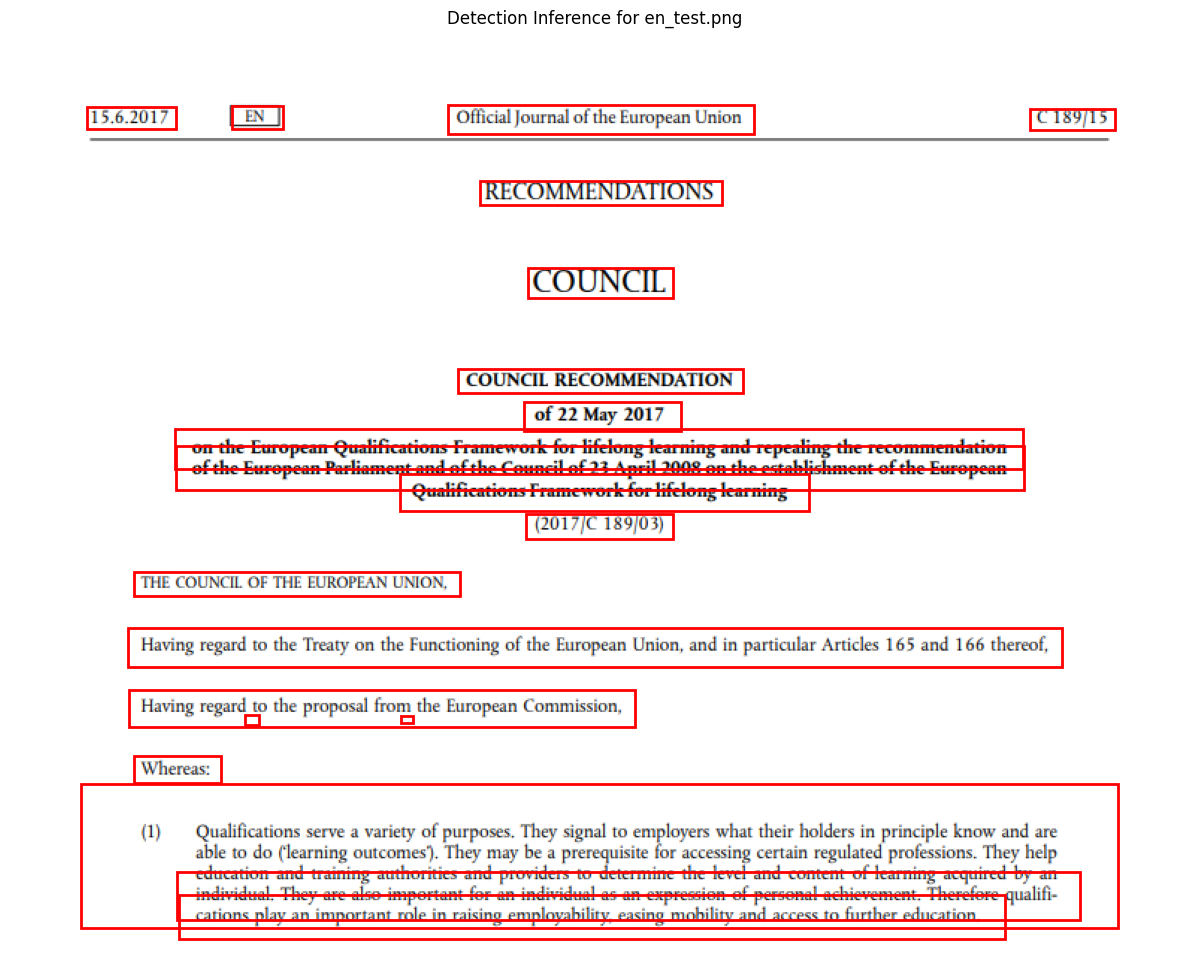

(array([[112.55625, 577.33125, 665.55   , 606.54375],
       [111.5775 , 561.95625, 715.46625, 593.475  ],
       [ 46.98   , 502.7625 , 740.91375, 598.85625],
       [ 82.215  , 484.3125 , 140.94   , 501.99375],
       [261.32625, 457.40625, 269.15625, 462.01875],
       [156.6    , 456.6375 , 166.3875 , 463.55625],
       [ 79.27875, 439.725  , 417.92625, 464.325  ],
       [ 78.3    , 398.2125 , 703.72125, 424.35   ],
       [ 82.215  , 360.54375, 300.47625, 376.6875 ],
       [344.52   , 322.10625, 443.37375, 339.01875],
       [260.3475 , 295.2    , 534.3975 , 319.8    ],
       [110.59875, 276.75   , 678.27375, 305.9625 ],
       [109.62   , 265.21875, 677.295  , 292.125  ],
       [343.54125, 246.76875, 448.2675 , 266.75625],
       [299.4975 , 225.24375, 490.35375, 241.3875 ],
       [346.4775 , 157.59375, 443.37375, 177.58125],
       [314.17875,  99.16875, 475.6725 , 115.3125 ],
       [682.18875,  50.7375 , 738.95625,  65.34375],
       [292.64625,  48.43125, 497.205  ,  67.

In [5]:
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T_vision
from doctr.models.detection import db_resnet50

print("=" * 100)
print("Step 7: Inference on test Image for Detection only")
print("=" * 100 + "\n")

def run_detection_inference(image_path: str, model_path: str = '/kaggle/working/best_detector_model.pth'):
     
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      
    detector = db_resnet50(pretrained=False, pretrained_backbone=False).to(device)

    try:
        detector.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded model from '{model_path}' successfully.")
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        return None, None

    detector.eval()
 
    detection_val_transforms = T_vision.Compose([
        T_vision.Resize((800, 800)),
        T_vision.ToTensor(),
        T_vision.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    if not os.path.exists(image_path):
        print(f"Error: The specified image path does not exist: {image_path}")
        return None, None
 
    original_image = Image.open(image_path).convert("RGB")
    original_width, original_height = original_image.size
 
    input_tensor = detection_val_transforms(original_image)
    input_batch = input_tensor.unsqueeze(0).to(device)
 
    with torch.no_grad():
        predictions = detector(input_batch)['preds'][0]

    detected_words_array = predictions['words']

    if detected_words_array.shape[0] > 0:
        detected_boxes_norm = detected_words_array[:, :4]
        detection_scores = detected_words_array[:, 4] 

        detected_boxes_abs = detected_boxes_norm * np.array(
            [original_width, original_height, original_width, original_height])
    else:
        detected_boxes_abs = np.array([])
        detection_scores = np.array([])
        print("No detections found for this image.")
 
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(original_image)
    ax.set_title(f"Detection Inference for {os.path.basename(image_path)}")

    for i, (x1, y1, x2, y2) in enumerate(detected_boxes_abs):
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none',
            label=f'Detected Box (Conf: {detection_scores[i]:.2f})' if i == 0 else ""
        )
        ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

    

    return detected_boxes_abs, detection_scores

print(run_detection_inference("/kaggle/input/test-data-for-cv-ccp/en_test.png"))

print("\n" + "=" * 100)
print("Step 7 Complete")
print("=" * 100)

# Fine-tuning DocTr for Recognition

## Step 1: Dataset Preparation for Fine-tuning

In [ ]:
import shutil

shutil.rmtree("/kaggle/working/doctr_rec_data")

In [ ]:
print("="*100)
print("Step 1: Dataset Preparation for Fine-tuning") 
print("="*100 + "\n")

try:
    import doctr
except ImportError:
    print("Installing doctr...")
    !pip install -q python-doctr[torch] 
    import doctr


import os
import json
from PIL import Image
import numpy as np
import warnings
from tqdm.auto import tqdm
import torch
from doctr.models.recognition import crnn_mobilenet_v3_small as build_crnn_model
from doctr.datasets import RecognitionDataset
from torch.utils.data import DataLoader
from doctr.datasets.utils import encode_string
 

warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

base_data_path = '/kaggle/input/xfund-and-funsd/XFUND and FUNSD/'
languages = ['en', 'de', 'fr', 'zh', 'ja', 'it', 'es', 'pt']

output_base_dir = '/kaggle/working/doctr_rec_data/'
train_output_img_dir = os.path.join(output_base_dir, 'train_cropped_images')
val_output_img_dir = os.path.join(output_base_dir, 'val_cropped_images')
os.makedirs(train_output_img_dir, exist_ok=True)
os.makedirs(val_output_img_dir, exist_ok=True)

train_gt_file = os.path.join(output_base_dir, 'train_gt.json')
val_gt_file = os.path.join(output_base_dir, 'val_gt.json')
vocab_file = os.path.join(output_base_dir, 'custom_vocab.txt')
 
MAX_ALLOWED_LABEL_LEN = 192  

data_already_processed = (
    os.path.exists(train_output_img_dir) and len(os.listdir(train_output_img_dir)) > 0 and
    os.path.exists(val_output_img_dir) and len(os.listdir(val_output_img_dir)) > 0 and
    os.path.exists(train_gt_file) and os.path.getsize(train_gt_file) > 0 and
    os.path.exists(val_gt_file) and os.path.getsize(val_gt_file) > 0 and
    os.path.exists(vocab_file) and os.path.getsize(vocab_file) > 0
)

if data_already_processed:
    print("Detected existing DocTR recognition data and vocabulary. Skipping preprocessing.")
else:
    print("Existing DocTR recognition data or vocabulary not found or incomplete. Starting preprocessing...")
 
    if os.path.exists(train_gt_file):
        os.remove(train_gt_file)
    if os.path.exists(val_gt_file):
        os.remove(val_gt_file)
    if os.path.exists(vocab_file):
        os.remove(vocab_file)

def process_annotations_and_collect_vocab(json_path, img_folder, output_img_dir, output_gt_file_json, global_unique_chars_set, max_label_length_to_filter):
    data_samples_count = 0
    gt_dict = {}
    filtered_count = 0  

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            full_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_path}. Skipping.")
        return 0, 0
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_path}. File might be corrupted. Skipping.")
        return 0, 0

    num_docs = len(full_data.get('documents', []))
    print(f"Processing {num_docs} documents from: {json_path}")

    for doc_idx, document in enumerate(tqdm(full_data.get('documents', []), desc="Documents")):
        doc_id = document.get('id')
        img_path_png = os.path.join(img_folder, f"{doc_id}.png")
        img_path_jpg = os.path.join(img_folder, f"{doc_id}.jpg")

        img_file_path = None
        if os.path.exists(img_path_png):
            img_file_path = img_path_png
        elif os.path.exists(img_path_jpg):
            img_file_path = img_path_jpg

        if not img_file_path:
            continue

        try:
            full_image = Image.open(img_file_path).convert("RGB")
        except Exception as e:
            continue

        for block_idx, block in enumerate(document.get('document', [])):
            if 'box' in block and 'text' in block:
                x1, y1, x2, y2 = block['box']
                text_content = block['text'].strip()
 
                if len(text_content) > max_label_length_to_filter:
                    filtered_count += 1
                    continue  

                left, upper, right, lower = x1, y1, x2, y2
                if not (0 <= left < right <= full_image.width and 0 <= upper < lower <= full_image.height):
                    continue
                if not text_content:
                    continue

                global_unique_chars_set.update(set(text_content))

                try:
                    cropped_img = full_image.crop((left, upper, right, lower))
                    if cropped_img.size[0] > 0 and cropped_img.size[1] > 0:
                        img_filename = f"{doc_id}_{block_idx}.png"
                        img_save_path = os.path.join(output_img_dir, img_filename)
                        cropped_img.save(img_save_path)

                        gt_dict[img_filename] = text_content
                        data_samples_count += 1
                except Exception as e:
                    continue

    with open(output_gt_file_json, 'w', encoding='utf-8') as f:
        json.dump(gt_dict, f, ensure_ascii=False, indent=4)

    print(f" --> Collected and saved {data_samples_count} samples for {os.path.basename(json_path)} to {output_img_dir} and {output_gt_file_json}")
    if filtered_count > 0:
        print(f"     (Note: {filtered_count} labels were filtered out because they exceeded {max_label_length_to_filter} characters.)")
    return data_samples_count, filtered_count  

if not data_already_processed:
    global_unique_chars = set()
    total_filtered = 0

    total_train_samples = 0
    for lang in languages:
        print(f"\n--- Loading and saving training data for language: {lang} ---")
        train_json_path_lang = os.path.join(base_data_path, f'{lang}.train.json')
        train_img_folder_lang = os.path.join(base_data_path, f'{lang}.train')
        collected_samples, filtered_samples = process_annotations_and_collect_vocab( 
            train_json_path_lang, train_img_folder_lang, train_output_img_dir, train_gt_file, global_unique_chars, MAX_ALLOWED_LABEL_LEN
        )
        total_train_samples += collected_samples
        total_filtered += filtered_samples
    print(f"\nTotal training samples (image-text pairs) saved: {total_train_samples}")

    total_val_samples = 0
    for lang in languages:
        print(f"\n--- Loading and saving validation data for language: {lang} ---")
        val_json_path_lang = os.path.join(base_data_path, f'{lang}.val.json')  
        val_img_folder_lang = os.path.join(base_data_path, f'{lang}.val')  
        collected_samples, filtered_samples = process_annotations_and_collect_vocab(  
            val_json_path_lang, val_img_folder_lang, val_output_img_dir, val_gt_file, global_unique_chars, MAX_ALLOWED_LABEL_LEN
        )
        total_val_samples += collected_samples
        total_filtered += filtered_samples
    print(f"\nTotal validation samples (image-text pairs) saved: {total_val_samples}")
    print(f"Total labels filtered out across all datasets: {total_filtered}")  

    print("\nCombining collected characters with DocTR's default model vocabulary...")
    dummy_model = build_crnn_model(pretrained=True).to(torch.device("cpu"))
    default_vocab = set(dummy_model.vocab)
    print(f"Is space in default_vocab (from DocTR model)? {' ' in default_vocab}")
    del dummy_model

    extended_vocab_chars = sorted(list(global_unique_chars.union(default_vocab)))
    extended_vocab_str = "".join(extended_vocab_chars)
    print(f"Is space in extended_vocab_str (before writing to file)? {' ' in extended_vocab_str}")

    with open(vocab_file, 'w', encoding='utf-8') as f:
        f.write(extended_vocab_str)
    print(f"Extended vocabulary saved to: {vocab_file}")
    print(f"Extended vocabulary length: {len(extended_vocab_str)}") 


print("\n" + "="*100)
print("Step 1 Complete")
print("="*100) 

## Step 2: Training Setup and Model Loading

In [ ]:
import os
import torch
from doctr.models.recognition import crnn_mobilenet_v3_small as build_crnn_model
from doctr.datasets import RecognitionDataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
import numpy as np

from typing import List, Tuple
from torch.utils.data._utils.collate import default_collate
 
class BatchGT:
    def __init__(
        self,
        data: torch.Tensor,
        gt_lengths: torch.Tensor,
        seq_len: torch.Tensor,
        original_labels: List[str],
    ) -> None:
        self.data = data
        self.gt_lengths = gt_lengths
        self.seq_len = seq_len
        self.original_labels = original_labels

    def __repr__(self) -> str:
        return f"BatchGT(data={self.data.shape}, gt_lengths={self.gt_lengths.shape}, seq_len={self.seq_len.shape})"

    def __len__(self) -> int:
        return self.gt_lengths.shape[0]

try:
    from doctr.datasets.utils import encode_string
except ImportError as e:
    raise ImportError("Cannot proceed without `encode_string`. Your `doctr` installation is fundamentally unusable.")


def custom_recognition_collate_fn(batches: List[Tuple[torch.Tensor, str]], vocab: str) -> Tuple[torch.Tensor, BatchGT]:
    images, labels_raw = zip(*batches)
    images = default_collate(images) 

    labels = []
    for l in labels_raw: 
        if isinstance(l, tuple) and len(l) == 1:
            labels.append(str(l[0]))   
        elif isinstance(l, str):
            labels.append(l) 
        else:
            raise TypeError(f"Unexpected label type encountered in collate_fn: {type(l)} with content: {l}") 

    
    encoded_tensors = []
    seq_len_labels = []

    for label in labels:
        encoded_result = encode_string(label, vocab)

        if isinstance(encoded_result, tuple):
            encoded_val_raw = encoded_result[0]
            seq_len_label = encoded_result[1]
        else:
            encoded_val_raw = encoded_result
            seq_len_label = len(encoded_val_raw)

        if not isinstance(encoded_val_raw, torch.Tensor):
            if isinstance(encoded_val_raw, list):
                encoded_tensor = torch.tensor(encoded_val_raw, dtype=torch.long)
            else:
                raise TypeError(f"Unexpected type for encoded label from encode_string: {type(encoded_val_raw)}")
        else:
            encoded_tensor = encoded_val_raw

        encoded_tensors.append(encoded_tensor)
        seq_len_labels.append(seq_len_label)

    gt = torch.cat(encoded_tensors)
    gt_lengths = torch.tensor(seq_len_labels, dtype=torch.long)

    expected_W_out = 192
    seq_len_tensor = torch.full((len(batches),), expected_W_out, dtype=torch.long)

    return images, BatchGT(gt, gt_lengths, seq_len_tensor, list(labels))

 
print("="*100)
print("Step 2: Training Setup and Model Loading")
print("="*100 + "\n")

output_base_dir = '/kaggle/working/doctr_rec_data/'
train_output_img_dir = os.path.join(output_base_dir, 'train_cropped_images')
val_output_img_dir = os.path.join(output_base_dir, 'val_cropped_images')
vocab_file = os.path.join(output_base_dir, 'custom_vocab.txt')
train_gt_file = os.path.join(output_base_dir, 'train_gt.json')
val_gt_file = os.path.join(output_base_dir, 'val_gt.json')


print(f"Loading extended vocabulary from: {vocab_file}")
with open(vocab_file, 'r', encoding='utf-8') as f:
    extended_vocab = f.read()

print("Loading training and validation datasets...")
rec_img_size = (32, 768)

recognition_transforms = T.Compose([
    T.Resize(rec_img_size),
])

train_dataset = RecognitionDataset(
    img_folder=train_output_img_dir,
    labels_path=train_gt_file,
    img_transforms=recognition_transforms,
)
val_dataset = RecognitionDataset(
    img_folder=val_output_img_dir,
    labels_path=val_gt_file,
    img_transforms=recognition_transforms,
)

batch_size = 32
num_workers = 0

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=lambda x: custom_recognition_collate_fn(x, extended_vocab)
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=lambda x: custom_recognition_collate_fn(x, extended_vocab)
)

print(f"Training DataLoader created with {len(train_dataloader)} batches of size {batch_size}")
print(f"Validation DataLoader created with {len(val_dataloader)} batches of size {batch_size}")


print("Initializing pre-trained DocTR recognition model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = build_crnn_model(
    pretrained=True,
    vocab=extended_vocab,
).to(device)


optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

num_epochs = 15
total_steps = len(train_dataloader) * num_epochs

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.1,
    div_factor=25,
    final_div_factor=1e4
)

print("\n" + "="*100)
print("Step 2 Complete")
print("="*100)

## Step 3: Training Loop Implementation

In [ ]:
import torch
from tqdm.auto import tqdm
import os
import torch.nn.functional as F

print("="*100)
print("Step 3: Training Loop Implementation")
print("="*100 + "\n")

save_dir = '/kaggle/working/doctr_rec_checkpoints/'
os.makedirs(save_dir, exist_ok=True)

best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

def _custom_compute_loss(self, model_output: torch.Tensor, target) -> torch.Tensor:
    logits = model_output.permute(1, 0, 2)
    log_probs = F.log_softmax(logits, dim=-1)

    if isinstance(target, BatchGT):
        gt = target.data
        gt_lengths = target.gt_lengths
    else:
        raise TypeError("Expected target to be a BatchGT object in custom_compute_loss.")

    batch_len = model_output.shape[0]
    input_length = torch.full((batch_len,), model_output.shape[1], dtype=torch.int32).to(model_output.device)

    loss = F.ctc_loss(
        log_probs,
        gt,
        input_length,
        gt_lengths,
        reduction='mean',
        zero_infinity=True
    )

    return loss

model.compute_loss = _custom_compute_loss.__get__(model, type(model)) 


print(f"Training for {num_epochs} epochs. Checkpoints will be saved in: {save_dir}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    train_running_loss = 0.0
    for batch_idx, (images, targets) in enumerate(tqdm(train_dataloader, desc="Training")):
        images = images.to(device)

        optimizer.zero_grad()
    
        output = model(images, targets)
        loss = output['loss']

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_running_loss += loss.item()

    avg_train_loss = train_running_loss / len(train_dataloader)
    history['train_loss'].append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(val_dataloader, desc="Validation")):
            images = images.to(device)
            output = model(images, targets)
            loss = output['loss']

            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_dataloader)
    history['val_loss'].append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_save_path = os.path.join(save_dir, f"best_doctr_rec_model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved best model with Validation Loss: {best_val_loss:.4f} to {model_save_path}")

print("\n" + "="*100)
print("Step 3 Complete")
print("="*100)

## Step 4: Model Evaluation (CER Calculation)

In [ ]:
!pip install jiwer -q

In [ ]:
import torch
from tqdm.auto import tqdm
import os
from doctr.models.recognition.predictor import RecognitionPredictor
from doctr.models.preprocessor import PreProcessor 
from jiwer import cer

print("\n" + "="*100)
print("Step 4: Model Evaluation (CER Calculation)")
print("="*100 + "\n")

save_dir = '/kaggle/working/doctr_rec_checkpoints/'

all_checkpoints = [f for f in os.listdir(save_dir) if f.startswith("best_doctr_rec_model_epoch_")]
if all_checkpoints:
    latest_best_checkpoint_filename = sorted(all_checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
    final_model_path = os.path.join(save_dir, latest_best_checkpoint_filename)
    print(f"Loading best model from: {final_model_path}")
else:
    print("No 'best' model checkpoint found. Please ensure training completed and saved checkpoints.")
    print("Skipping CER calculation as no model to load.")
    final_model_path = None

if final_model_path and os.path.exists(final_model_path):
    model.load_state_dict(torch.load(final_model_path, map_location=device))
    model.eval()
 
    output_height, output_width = rec_img_size 
    mean = (0.694, 0.695, 0.693) # Default DocTr values
    std = (0.299, 0.297, 0.301)  # Default DocTr values
    
    doc_predictor_preprocessor = PreProcessor(
        output_size=(output_height, output_width),
        mean=mean,
        std=std,
        batch_size=val_dataloader.batch_size
    )
    
    predictor = RecognitionPredictor(pre_processor=doc_predictor_preprocessor, model=model) 

    all_preds = []
    all_gts = []

    print("Calculating CER on the validation set...")
    with torch.no_grad():
        for images, targets_batchgt in tqdm(val_dataloader, desc="Calculating CER"):
            images = images.to(device) 
 
            predictions = predictor(images) 
            for pred_item in predictions:
                if isinstance(pred_item, tuple) and len(pred_item) > 0 and isinstance(pred_item[0], str):
                    all_preds.append(pred_item[0]) 
                elif isinstance(pred_item, str):
                    all_preds.append(pred_item) 
                else: 
                    print(f"Warning: Unexpected prediction item type: {type(pred_item)}, content: {pred_item}")
                    all_preds.append(str(pred_item))  
             
            all_gts.extend(targets_batchgt.original_labels)
 

    final_cer = cer(all_gts, all_preds)
    print(f"\nFinal Character Error Rate (CER) on Validation Set: {final_cer:.4f}")
else:
    print("\nCER calculation skipped because no model was loaded.")

print("\n" + "="*100)
print("Step 4 Complete")
print("="*100)

## Step 5: Graphs

In [ ]:
import matplotlib.pyplot as plt
 

if 'history' in locals() and history['train_loss'] and history['val_loss']:
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Training history data not found or is empty. Please ensure Step 3 was run and 'history' was populated.")

# Inference

In [25]:
import os
import shutil
import torch
from doctr.io import DocumentFile
from doctr.models.recognition import crnn_mobilenet_v3_small
from doctr.models.preprocessor.pytorch import PreProcessor
from doctr.models.recognition.predictor import RecognitionPredictor
from PIL import Image
import numpy as np
from uuid import uuid4


def run_doctr_ocr_inference(
    image_or_pdf_path: str,
    finetuned_reco_model_path: str,
    vocab: str,
    output_dir: str = '/kaggle/working/inference_results',
    preserve_aspect_ratio: bool = True,
    symmetric_pad: bool = True,
):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

    if not vocab:
        raise ValueError("Custom vocabulary (vocab) must be provided and non-empty for inference.")
    
    os.makedirs(output_dir, exist_ok=True)
    temp_dir = os.path.join("/kaggle/working", f"temp_pages")
    os.makedirs(temp_dir, exist_ok=True)
 
    if image_or_pdf_path.lower().endswith('.pdf'):
        doc = DocumentFile.from_pdf(image_or_pdf_path)
        print(f"PDF contains {len(doc)} pages.")
        image_paths = []
        for i, page in enumerate(doc):
            img = page.render()
            img_path = os.path.join(temp_dir, f"page_{i+1}.png")
            img.save(img_path)
            image_paths.append(img_path)
    else:
        image_paths = [image_or_pdf_path]
 
    reco_model = crnn_mobilenet_v3_small(pretrained=False, vocab=vocab).to(device)
    input_shape = reco_model.cfg["input_shape"][-2:]
    preprocessor = PreProcessor(
        output_size=input_shape,
        preserve_aspect_ratio=preserve_aspect_ratio,
        symmetric_pad=symmetric_pad,
        batch_size=1
    )
    reco_predictor = RecognitionPredictor(preprocessor, reco_model).to(device)

    if os.path.exists(finetuned_reco_model_path):
        print(f"Loading recognition model from: {finetuned_reco_model_path}")
        reco_model.load_state_dict(torch.load(finetuned_reco_model_path, map_location=device))
        print("Recognition model loaded successfully.")
    else:
        raise FileNotFoundError(f"Recognition model weights not found at {finetuned_reco_model_path}")
 
    for i, img_path in enumerate(image_paths):
        print(f"\n=== Processing Page {i+1}: {img_path} ===")

        boxes, _ = run_detection_inference(img_path)

        if boxes is None or len(boxes) == 0:
            print(f"No detections found in image: {img_path}")
            continue

        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)

        print("Recognition Results:")
        for j, (x1, y1, x2, y2) in enumerate(boxes.astype(int)):
            cropped = image_np[y1:y2, x1:x2]
            if cropped.size == 0: 
                continue
            if cropped.shape[0] < 10 or cropped.shape[1] < 10: 
                continue
            cropped_img = Image.fromarray(cropped)
            cropped_np = np.array(cropped_img)

            try:
                prediction = reco_predictor([cropped_np])[0]
                print(f"Box {j+1}: {prediction}")
            except Exception as e:
                print(f"Box {j+1}: Recognition error - {e}")
 
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
        print(f"Cleaned up temporary directory: {temp_dir}")


Loaded vocabulary from: /kaggle/working/doctr_rec_data/custom_vocab.txt
Loading recognition model from: /kaggle/working/doctr_rec_checkpoints/best_doctr_rec_model_epoch_14.pt
Recognition model loaded successfully.

=== Processing Page 1: /kaggle/input/test-data-for-cv-ccp/de_test.png ===
Loaded model from '/kaggle/working/best_detector_model.pth' successfully.


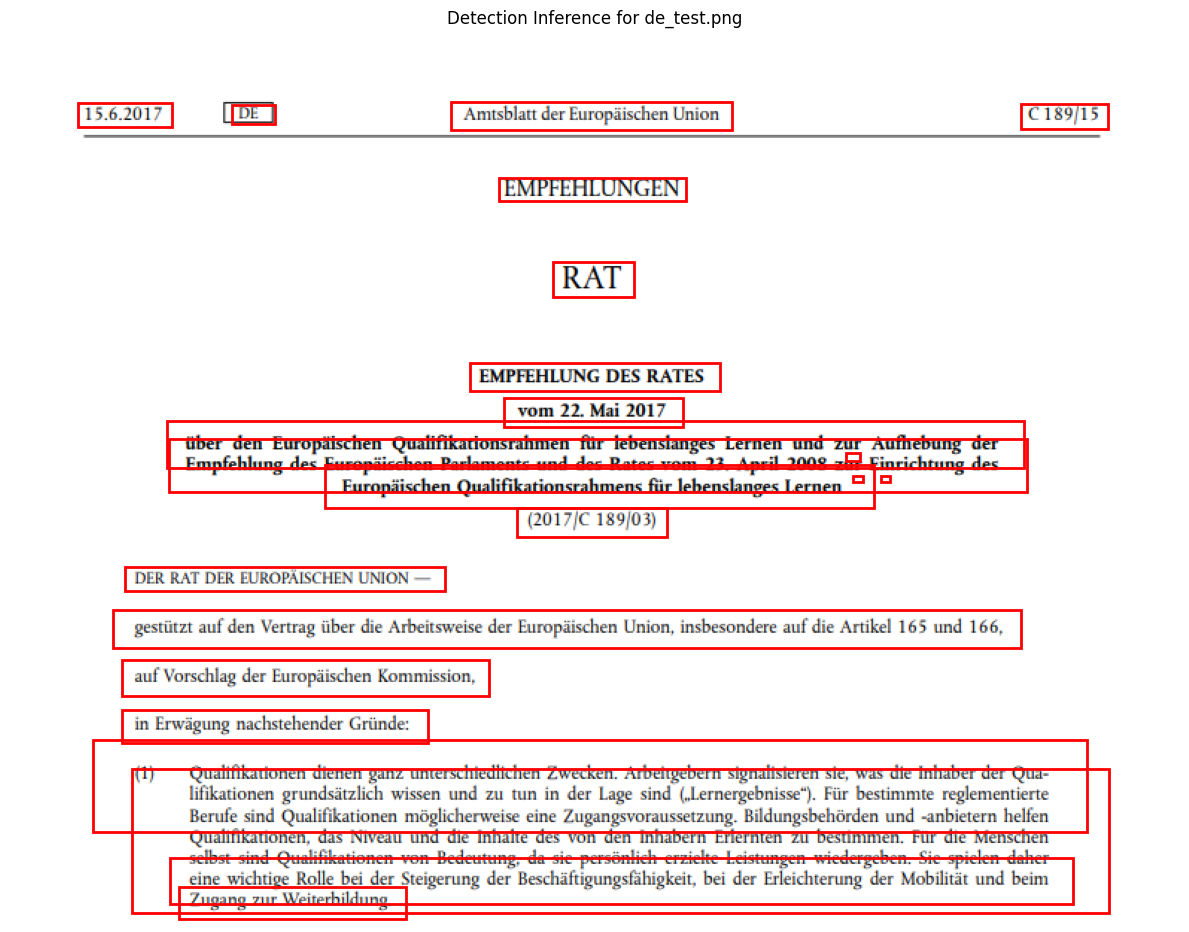

Recognition Results:
Box 1: (' Ss s s s ist cousi a e a ', 0.15786205232143402)
Box 2: ('r a sa e e t at a s ua(r eé s es se t ', 0.12458527833223343)
Box 3: (' a a ', 0.15049512684345245)
Box 4: (' a m a a ', 0.2146380990743637)
Box 5: ('t ar s e s s s st s s o ', 0.14888906478881836)
Box 6: ('r e s s t eseser e se o ', 0.12807899713516235)
Box 7: (' vr s saã ãali s ã is d r o s se c s sa ro Ã ', 0.15055790543556213)
Box 8: (' a a a o p IÃ c u l N u ', 0.1269311159849167)
Box 9: (' 2 0 1 7 C 1 5 0 ) ', 0.18458980321884155)
Box 12: (' P er a s r e s t e a a e  tg tr eu s fre ta l', 0.0815887451171875)
Box 14: (' S dr c e a a se vcs Ã e o e tbl ar e e e E n l s t a ', 0.10862384736537933)
Box 15: (' S sa s a ses e @ c ce a e e s ad s Ã a s sa ', 0.10891600698232651)
Box 16: (' v e e A a 2 o ', 0.17565582692623138)
Box 17: (' s s a t o r s s x a e ', 0.081290103495121)
Box 18: (' A T ', 0.7793136239051819)
Box 19: (' / l d un u u o e a o ', 0.09835368394851685)
Box 20: (' C 1 8 1 5 ', 0.

In [27]:
vocab_path = '/kaggle/working/doctr_rec_data/custom_vocab.txt'

if os.path.exists(vocab_path):
    with open(vocab_path, 'r', encoding='utf-8') as f:
        extended_vocab = f.read()
    print(f"Loaded vocabulary from: {vocab_path}")
else:
    raise FileNotFoundError(f"❌ Vocabulary file not found at: {vocab_path}")


run_doctr_ocr_inference(
    image_or_pdf_path="/kaggle/input/test-data-for-cv-ccp/en_test.png",
    finetuned_reco_model_path="/kaggle/working/doctr_rec_checkpoints/best_doctr_rec_model_epoch_14.pt",
    vocab=extended_vocab, 
)
